In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deep_hvac import ppo, runner, simulator, util

/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/easyrl/envs/shmem_vec_env.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool: ctypes.c_bool}


In [2]:
expert_light = pd.read_pickle('../data/results-expert-light.pickle')
expert_frame = util.load_expert_performance(expert_light)

In [3]:
env_light, env_name_light = runner.make_default_env(
    discrete_action=True, expert_performance=expert_light['expert_performance'],
    season='summer', capacitance='light')


2022-04-29 21:43:40,311 - deep_hvac - DEBUG - Creating environment DefaultBuilding-light-v0-action-discrete-summer.
2022-04-29 21:43:40,312 - deep_hvac - DEBUG - Loading NSRDB data...
2022-04-29 21:43:40,595 - deep_hvac - DEBUG - Finished loading NSRDB data.
2022-04-29 21:43:40,596 - deep_hvac - DEBUG - Loading Houston price data...
2022-04-29 21:43:40,600 - deep_hvac - DEBUG - Finished loading price data.


[INFO][2022-04-29 21:43:40]: Creating 1 environments.
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
/home/oski/.virtualenvs/6484-proj/lib/python3.8/site-packages/easyrl/envs/dummy_vec_env.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.buf_dones = np.zeros((self.num_envs,), dtype=np.bool)


In [4]:
agent = ppo.load_agent(f'../data/{env_name_light}/seed_0/model/model_best.pt',
                       env_name_light)

[INFO][2022-04-29 21:43:40]: Creating 1 environments.
[INFO][2022-04-29 21:43:40]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-04-29 21:43:40]: Loading model from ../data/DefaultBuilding-light-v0-action-discrete-summer/seed_0/model/model_best.pt


In [64]:
def results_to_dataframes(results_dict):
    out = {}
    for k, v in results_dict.items():
        if k == 'timestamp':
            continue
        out[k] = pd.DataFrame(
            np.array(v).T,
            index=results_dict['timestamp'][0]
        )

    return pd.concat(out.values(), axis=1, keys=out.keys())


def comfort_violations(frame):
    """Return dataframe with comfort penalty scores."""
    frame = frame.copy()
    if isinstance(frame.columns, pd.MultiIndex):
        for episode in frame['t_outside'].columns:
            frame[('comfort_penalty', episode)] = frame.apply(
                lambda row: simulator.comfort_penalty(
                    row['t_outside'][episode],
                    row['t_inside'][episode]),
                axis=1
            )
    else:
        frame['comfort_penalty'] = frame.apply(
            lambda row: simulator.comfort_penalty(
                row['t_outside'], row['t_inside']
            ), axis=1
        )
    return frame

In [51]:
jan1 = dt.datetime(2018, 1, 1, 0, 0)
monthly_results = {}
n_runs = 2
for month in (6, 7, 8):
# for month in range(12):
    start = dt.datetime(2018, month + 1, 1, 0, 0)
    start_int = int((start - jan1).total_seconds() / 3600)
    results = runner.get_results(agent, env_light, time=start_int,
                                 max_steps=24*30*n_runs)
    monthly_results[month + 1] = results_to_dataframes(results)

In [76]:
comfort_violations(expert_frame)['comfort_penalty']

2018-01-01 01:00:00-06:00    0.0
2018-01-01 02:00:00-06:00    0.0
2018-01-01 03:00:00-06:00    0.0
2018-01-01 04:00:00-06:00    0.0
2018-01-01 05:00:00-06:00    0.0
                            ... 
2018-12-31 18:00:00-06:00    0.0
2018-12-31 19:00:00-06:00    0.0
2018-12-31 20:00:00-06:00    0.0
2018-12-31 21:00:00-06:00    0.0
2018-12-31 22:00:00-06:00    0.0
Name: comfort_penalty, Length: 8758, dtype: float64

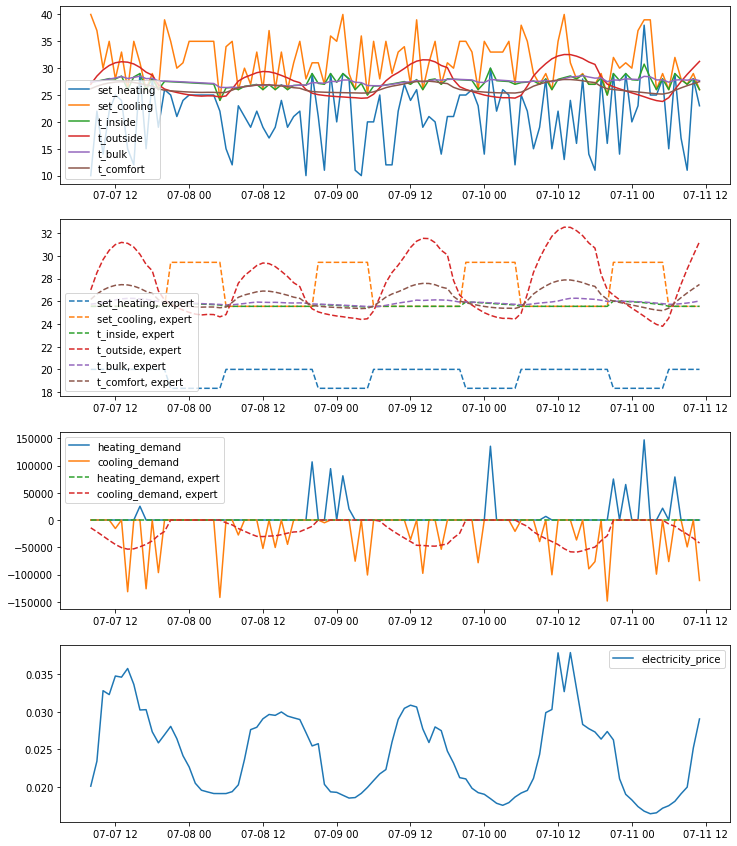

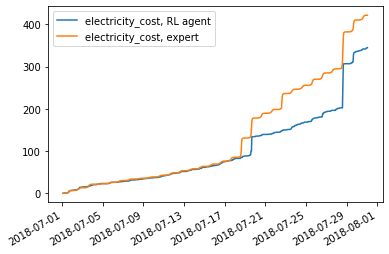

In [15]:
def plot_month(month, monthlies, fields, idx_start=0, n_points=None):
    data = monthlies[month]
    if n_points:
        data = {k: v[idx_start:n_points + idx_start]
                for k, v in data.items()}
    timestamps = data['timestamp']
    for field in fields:
        plt.plot(timestamps, data[field].mean(axis=1).values,
                 label=field)
    plt.legend()


def plot_expert(expert, month, monthlies, fields, idx_start=0,
                n_points=None, linestyle='solid'):
    if n_points is None:
        end = None
    else:
        end = n_points + idx_start
    times = monthlies[month]['timestamp'][
        slice(idx_start, end)
    ]
    for field in fields:
        plt.plot(times, expert.loc[times, field],
                 label=field + ', expert', linestyle=linestyle)
    plt.legend()
    

def compare_cumsum(month, monthlies, fields, expert_frame,
                   idx_start=0, n_points=None):
    data = monthlies[month]
    if n_points:
        data = {k: v[idx_start:n_points + idx_start]
                for k, v in data.items()}
    timestamps = data['timestamp']
    for field in fields:
        plt.plot(timestamps, data[field].cumsum().values,
                 label=f'{field}, RL agent')
        expert_frame.loc[timestamps, field].cumsum().plot(
            label=f'{field}, expert')
    plt.legend()
    
    
start = 150
month = 7
    
fig, axs = plt.subplots(4, figsize=(12, 15))
plt.sca(axs[0])
plot_month(month, monthly_results,
           ('set_heating', 'set_cooling', 't_inside', 't_outside',
            't_bulk',
            't_comfort'),
           idx_start=start,
           n_points=100)
plt.sca(axs[1])
plot_expert(expert_frame, month, monthly_results,
            ('set_heating', 'set_cooling', 't_inside', 't_outside',
             't_bulk',
             't_comfort'),
            idx_start=start, n_points=100, linestyle='dashed')
plt.sca(axs[2])
plot_month(month, monthly_results,
           ('heating_demand', 'cooling_demand'),
           idx_start=start,
           n_points=100)
plot_expert(expert_frame, month, monthly_results,
            ('heating_demand', 'cooling_demand'),
            idx_start=start, n_points=100, linestyle='dashed')
plt.sca(axs[3])

plot_month(month, monthly_results,
           ('electricity_price',),
           idx_start=start,
           n_points=100)


plt.figure()
compare_cumsum(month, monthly_results, ['electricity_cost'],
               expert_frame, idx_start=0, n_points=None)

In [11]:
monthly_results[7]['electricity_cost'].max()

0    33.94346
dtype: float64

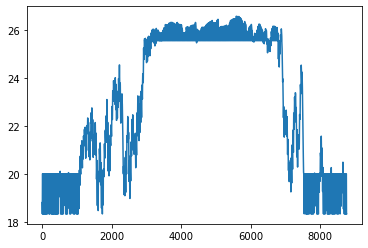

In [12]:
plt.plot(expert['t_air'])

In [13]:
expert_frame = util.load_expert_performance(expert)

In [14]:
expert_frame['electricity_cost'].max()

46.524357331655715

In [15]:
expert_frame['reward'].max()

0.01772759400712306

In [ ]:
for k, v in expert.items():
    print(k, len(v))